# Facial Emotion Recognition on Real Time Video Using XCEPTION CNN
* We first build a CNN Architecture that employs residual networks to modify the desired mapping between two subsequent layers, so that the learned features become the difference of the original feature map and the desired features.
* We have attempted to emulate the results of the following paper : Real-time Convolutional Neural Networks for Emotion and Gender Classification
* A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

Imports

In [0]:
'''
Making Imports
'''

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
import random
import sys
import pandas as pd
import cv2
import numpy as np

## Load Data

In [0]:
def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    print ('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training',classes=['Angry','Happy'], filepath='fer2013.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

## Split Data

In [0]:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']
'''
Making Train Test Validation splits
'''

X_test, y_test = load_data(sample_split=1.0,classes=emo,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo,
usage= 'PublicTest')

Disgust classified as Angry


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Disgust classified as Angry
Disgust classified as Angry


In [0]:
#check shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 48, 48, 1)
(28709, 6)
(3589, 48, 48, 1)
(3589, 6)
(3589, 48, 48, 1)
(3589, 6)


In [0]:
def save_data(X_test, y_test, fname=''):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)
save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (zip(labels, counts))

Private test set


## Plotting Images

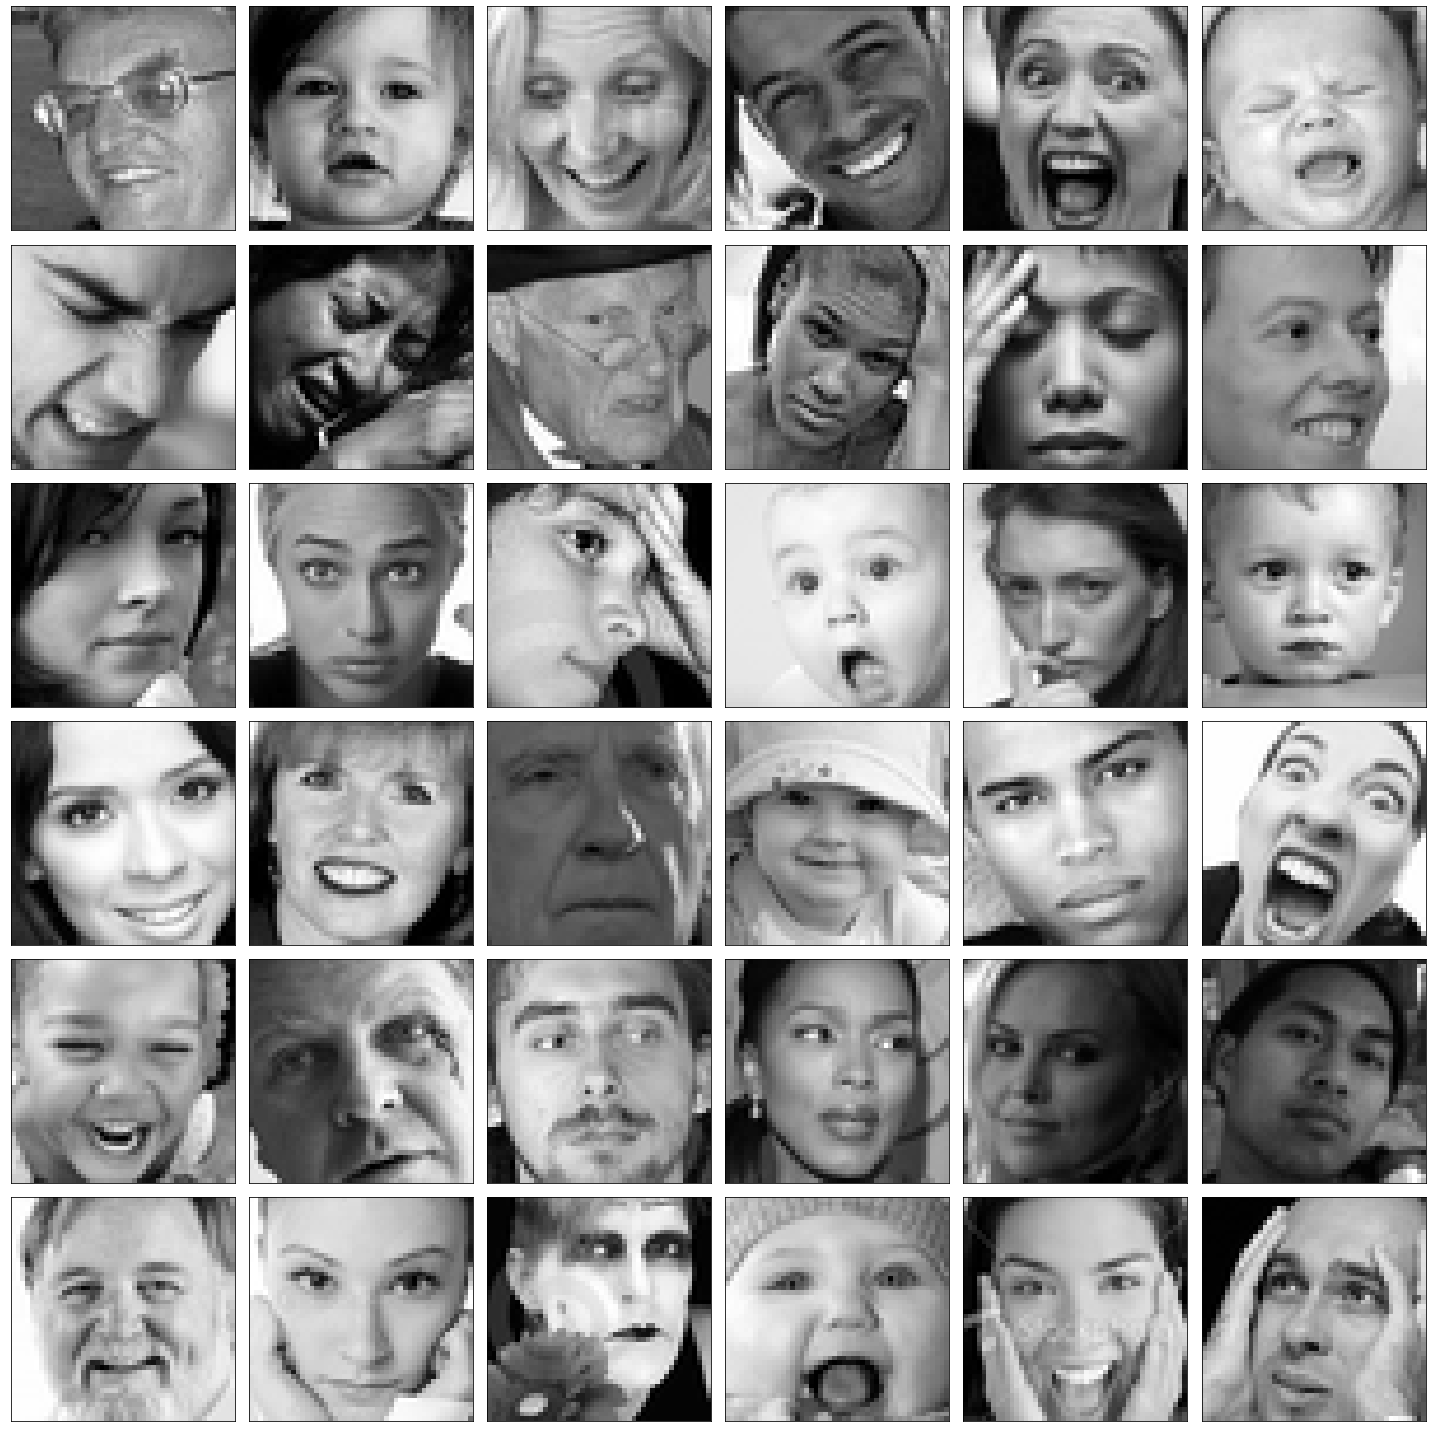

In [0]:
'''
Plotting Input Images
'''

import matplotlib
import matplotlib.pyplot as plt
def overview(start, end, X):
    """
    The function is used to plot first several pictures for overviewing inputs format
    """
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,35, X)

(4, 48, 48, 1)


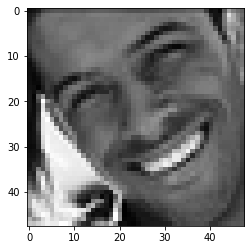

In [0]:
input_img = X[3:7,:,:,:] 
print (input_img.shape)
plt.imshow(input_img[0,:,:,0], cmap='gray')
plt.show()

In [0]:
y_train = y_train 
y_public = y_val 
y_private = y_test 
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]

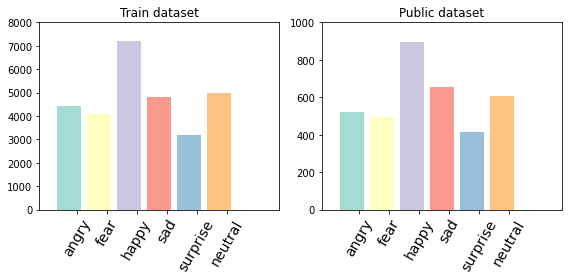

In [0]:
'''
Bar plot for label count in train and test sets
'''

import brewer2mpl
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    """
    The function is used to plot the distribution of the labels of provided dataset 
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,7), np.bincount(y1), color=colorset, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,7), np.bincount(y2), color=colorset, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_train_labels, y_public_labels, \
                  ['Train dataset', 'Public dataset'], \
                  ylims =[8000,1000])

## Define Architecture

In [0]:
batch_size = 32
num_epochs = 30
input_shape = (48, 48, 1)
verbose = 1
num_classes = 6
patience = 50
base_path = '/content/'
l2_regularization=0.01

In [0]:
regularization = l2(l2_regularization)
#regularize the input

In [0]:
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

In [0]:
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

In [0]:
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

In [0]:
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])

In [0]:
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 46, 46, 8)    72          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 46, 46, 8)    32          conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 46, 46, 8)    0           batch_normalization_29[0][0]     
____________________________________________________________________________________________

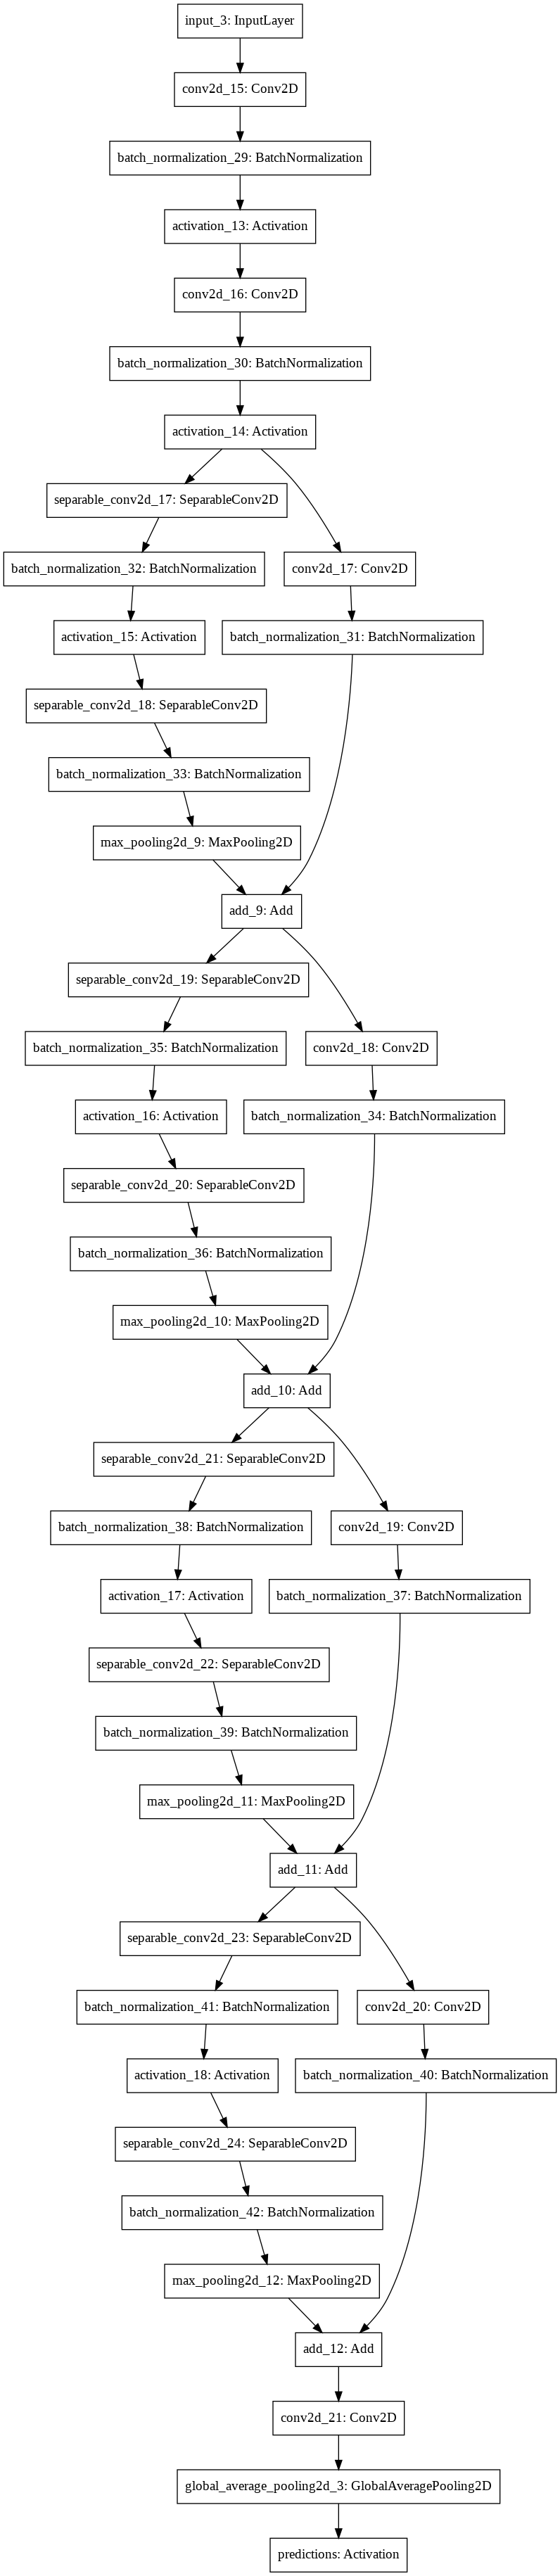

In [0]:
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Training

In [0]:
# callbacks
#log_file_path = base_path + '_emotion_training.log'
#csv_logger = CSVLogger(log_file_path, append=False)
#early_stop = EarlyStopping('val_loss', patience=patience)
#reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.h5'
#model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
#callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]
modelF = model.fit(xtrain, ytrain, nb_epoch=20, batch_size=128,  
          validation_data=(xtest,ytest), shuffle=True, verbose=1)
#model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
#                        steps_per_epoch=len(xtrain) / batch_size,
##                        epochs=num_epochs, verbose=1, callbacks=callbacks,
#                       validation_data=(xtest,ytest))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 28709 samples, validate on 7178 samples
Epoch 1/20
28709/28709 [==============================] - 220s 8ms/step - loss: 1.0930 - accuracy: 0.5905 - val_loss: 1.1732 - val_accuracy: 0.5607
Epoch 2/20
28709/28709 [==============================] - 217s 8ms/step - loss: 1.0474 - accuracy: 0.6104 - val_loss: 1.1277 - val_accuracy: 0.5808
Epoch 3/20
28709/28709 [==============================] - 216s 8ms/step - loss: 1.0163 - accuracy: 0.6225 - val_loss: 1.0942 - val_accuracy: 0.5899
Epoch 4/20
28709/28709 [==============================] - 219s 8ms/step - loss: 0.9838 - accuracy: 0.6337 - val_loss: 1.1431 - val_accuracy: 0.5659
Epoch 5/20
28709/28709 [==============================] - 215s 8ms/step - loss: 0.9494 - accuracy: 0.6507 - val_loss: 1.1237 - val_accuracy: 0.5875
Epoch 6/20
28709/28709 [==============================] - 216s 8ms/step - loss: 0.9212 - accuracy: 0.6611 - val_loss: 1.0925 - val_accuracy: 0.6018
Epoch 7/20
28709/28709 [==============================] - 222s 

## Plotting Results

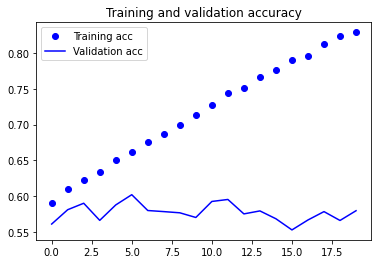

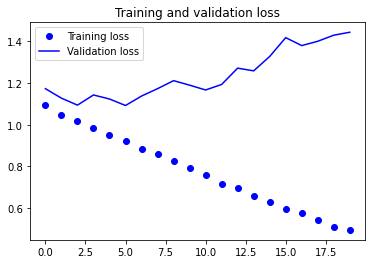

In [0]:
import matplotlib.pyplot as plt
acc = modelF.history['accuracy']
val_acc = modelF.history['val_accuracy']
loss = modelF.history['loss']
val_loss = modelF.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()


In [0]:
score = model.evaluate(xtest,ytest, verbose=0)
print ("model %s on test data: %.2f%% " % (model.metrics_names[1], score[1]*100))

model accuracy on test data: 57.94% 
